In [19]:
import pandas as pd
import numpy as np
from loaders import wind_data

TEST_SIZE = 50
TRAIN_SIZE = 681

wind_GEF = wind_data(path_name='data/wind_data_all_zone.csv', test_size=TEST_SIZE, random_state=0)
wind_df = pd.read_csv('data/wind_data_all_zone.csv')

wind_df['TIMESTAMP'] =  pd.to_datetime(wind_df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S.%f')
wind_df['new_date'] = [d.date() for d in wind_df['TIMESTAMP']]
wind_df

#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days
#LS 631 days #VS 50 days # TEST 50 days


,TIMESTAMP,TARGETVAR,U10,V10,U100,V100,ZONE_1,ZONE_2,ZONE_3,ZONE_4,ZONE_5,ZONE_6,ZONE_7,ZONE_8,ZONE_9,ZONE_10,new_date
0,2012-01-01 01:00:00,0.000000,2.124600,-2.681966,2.864280,-3.666076,1,0,0,0,0,0,0,0,0,0,2012-01-01
1,2012-01-01 02:00:00,0.054879,2.521695,-1.796960,3.344859,-2.464761,1,0,0,0,0,0,0,0,0,0,2012-01-01
2,2012-01-01 03:00:00,0.110234,2.672210,-0.822516,3.508448,-1.214093,1,0,0,0,0,0,0,0,0,0,2012-01-01
3,2012-01-01 04:00:00,0.165116,2.457504,-0.143642,3.215233,-0.355546,1,0,0,0,0,0,0,0,0,0,2012-01-01
4,2012-01-01 05:00:00,0.156940,2.245898,0.389576,2.957678,0.332701,1,0,0,0,0,0,0,0,0,0,2012-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175435,2013-12-31 20:00:00,0.792143,1.032363,-6.281558,2.041033,-11.220655,0,0,0,0,0,0,0,0,0,1,2013-12-31
175436,2013-12-31 21:00:00,0.792143,1.702361,-6.202448,2.846245,-10.486079,0,0,0,0,0,0,0,0,0,1,2013-12-31
175437,2013-12-31 22:00:00,0.792143,5.086629,-1.261378,7.382256,-3.097656,0,0,0,0,0,0,0,0,0,1,2013-12-31
175438,2013-12-31 23:00:00,0.792143,4.183751,-1.580172,5.789054,-2.116548,0,0,0,0,0,0,0,0,0,1,2013-12-31


In [69]:
import datetime
first_date = datetime.date(2012, 1, 1)

test_dates = []
for d in wind_GEF[5].index:
    test_dates.append(d.date())

train_dates = []
for d in wind_GEF[1].index:
    if d.date() != first_date:
        train_dates.append(d.date())
for d in wind_GEF[3].index:
    train_dates.append(d.date())

test_dates = pd.Series(test_dates)
train_dates = pd.Series(train_dates)
train = wind_df[~wind_df['new_date'].isin(test_dates.unique())].copy()
test = wind_df[wind_df['new_date'].isin(test_dates.unique())].copy()
x_train = train[['U10', 'V10', 'U100', 'V100', 'ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']]
x_test = test[['U10', 'V10', 'U100', 'V100', 'ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']]
y_train = train['TARGETVAR']
y_test = test['TARGETVAR']

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

num_quantiles = 100
quantiles = np.arange(0, 1, 1/num_quantiles)[1:]
#quantiles = [0.05, 0.5, 0.95]

common_params = dict(
    learning_rate=0.05,
    n_estimators=600,
    max_depth=7,
    min_samples_leaf=9,
    min_samples_split=9,
)

predictions = []
train_predictions = []
for alpha in quantiles:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    model = gbr.fit(x_train, y_train)
    y_pred = gbr.predict(x_test)

    x_pred = gbr.predict(x_train)
    predictions.append(y_pred)
    train_predictions.append(x_pred)
predictions = np.array(predictions)
train_predictions = np.array(train_predictions)

In [22]:
sorted_predictions = np.sort(predictions, axis=0)
sorted_train_predictions = np.sort(train_predictions, axis=0)

results = []
for i, q in enumerate(quantiles):
    results.append(mean_pinball_loss(y_test, sorted_predictions[i], alpha=q))

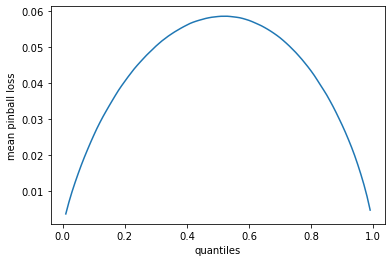

In [23]:
import matplotlib.pyplot as plt

plt.plot(quantiles, results)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()

Quantile sqore: 4.231340508052588


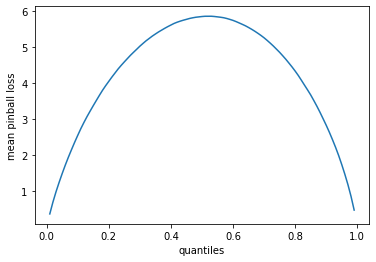

In [24]:
import metrics

plf = metrics.plf_per_quantile(sorted_predictions, y_test)
print("Quantile sqore:", plf.mean())
plt.plot(quantiles, plf)
plt.ylabel('mean pinball loss')
plt.xlabel('quantiles')
plt.show()

In [25]:
y_copy = pd.DataFrame(y_test.copy())
y_copy['pos'] = np.arange(y_test.shape[0])
y_copy['old_pos'] = y_copy.index
y_copy

,TARGETVAR,pos,old_pos
23,0.760455,0,23
24,0.439244,1,24
25,0.205808,2,25
26,0.190020,3,26
27,0.803496,4,27
...,...,...,...
175386,0.342493,11995,175386
175387,0.285135,11996,175387
175388,0.210316,11997,175388
175389,0.135190,11998,175389


C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:630: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\kolom\miniconda3\lib\site-packages\scipy\interpolate\interpolate.py:633: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


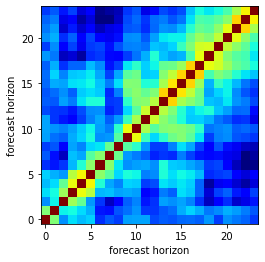

In [26]:
import copula
idx = np.arange(TEST_SIZE)
np.random.shuffle(idx)
ZONE = 'ZONE_6'
cov_matrix = np.identity(24)

for i in idx:
    pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[ZONE] == 1)].index)]['pos']].T)
    actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[ZONE] == 1)].index)]['TARGETVAR']
    cov_matrix = copula.update_cov_matrix(df_y_pred_q=pred, quantiles=quantiles, 
                      actual_data=actual_data, forget_factor=0.98, cov_matrix=cov_matrix)
    
plt.imshow(cov_matrix, cmap='jet', origin='lower')
plt.xlabel('forecast horizon')
plt.ylabel('forecast horizon')

plt.show()

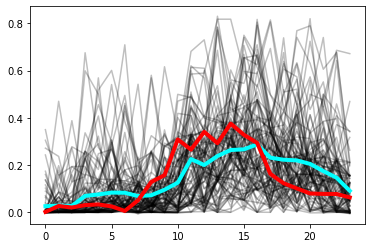

In [27]:
N_SCENARIOS = 100

ZONE = 'ZONE_6'
pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[-1]) & (wind_df[ZONE] == 1)].index)]['pos']].T)
actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[-1]) & (wind_df[ZONE] == 1)].index)]['TARGETVAR']

generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrix, n_scenarios=100, rnd_seed=[0], sort=True)
plt.plot(generated_scenarios.values, color='k', alpha=0.25)
plt.plot(generated_scenarios.values.mean(axis=1), color='cyan', label='Generated Scenarios Mean', linewidth=4)
plt.plot(np.arange(24), actual_data, color='red', linewidth=4)
plt.show()

In [28]:
ZONES = ['ZONE_1', 'ZONE_2', 'ZONE_3','ZONE_4','ZONE_5','ZONE_6','ZONE_7','ZONE_8','ZONE_9','ZONE_10']
y_to_pass = []
scenarios_pred = []
for zone in ZONES:

    for i in range(TEST_SIZE):
        pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrix, n_scenarios=N_SCENARIOS, rnd_seed=[0], sort=True)
        scenarios_pred.append(generated_scenarios)
        y_to_pass.append(actual_data)


In [29]:
y_to_pass = np.array(y_to_pass)

scenarios_pred = np.array(scenarios_pred)
scenarios_pred = scenarios_pred.reshape(-1, N_SCENARIOS)
scenarios_pred.shape

(12000, 100)

In [30]:
import metrics

energy_scoring = metrics.energy_score(scenarios_pred, y_to_pass)
np.array(energy_scoring).mean() * 100

53.28387182802923

In [75]:
import copula
y_train_copy = pd.DataFrame(y_train.copy())
y_train_copy['pos'] = np.arange(y_train.shape[0])
y_train_copy['old_pos'] = y_train_copy.index

TRAIN_SIZE = 681 - 1
idx = np.arange(TRAIN_SIZE)
np.random.shuffle(idx)

cov_matrixes = {}
for zone in zones:
    cov_matrixes[zone] = np.identity(24)
    for i in idx:
        pred = pd.DataFrame(sorted_train_predictions[:,y_train_copy[y_train_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == train_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_train_copy[y_train_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == train_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        cov_matrixes[zone] = copula.update_cov_matrix(df_y_pred_q=pred, quantiles=quantiles, 
                          actual_data=actual_data, forget_factor=0.99, cov_matrix=cov_matrixes[zone])
        
y_to_pass = []
scenarios_pred = []
for zone in zones:

    for i in range(TEST_SIZE):
        pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrixes[zone], n_scenarios=N_SCENARIOS, rnd_seed=[0], sort=True)
        scenarios_pred.append(generated_scenarios)
        y_to_pass.append(actual_data)

y_to_pass = np.array(y_to_pass)

scenarios_pred = np.array(scenarios_pred)
scenarios_pred = scenarios_pred.reshape(-1, N_SCENARIOS)

energy_scoring = metrics.energy_score(scenarios_pred, y_to_pass)
print("Average energy score:", np.array(energy_scoring).mean() * 100)

Average energy score: 53.150905672954075


In [77]:
for zone in zones:
    y_to_pass = []
    scenarios_pred = []
    for i in range(TEST_SIZE):
        pred = pd.DataFrame(sorted_predictions[:,y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['pos']].T)
        actual_data = y_copy[y_copy['old_pos'].isin(wind_df[(wind_df['new_date'] == test_dates.unique()[i]) & (wind_df[zone] == 1)].index)]['TARGETVAR']
        generated_scenarios = copula.sample_from_quantiles(df_y_pred_q=pred, quantiles=quantiles, cov_matrix=cov_matrixes[zone], n_scenarios=N_SCENARIOS, rnd_seed=[0], sort=True)
        scenarios_pred.append(generated_scenarios)
        y_to_pass.append(actual_data)
        
    y_to_pass = np.array(y_to_pass)

    scenarios_pred = np.array(scenarios_pred)
    scenarios_pred = scenarios_pred.reshape(-1, N_SCENARIOS)
    energy_scoring = metrics.energy_score(scenarios_pred, y_to_pass)

    print("Average energy score in ", zone, np.array(energy_scoring).mean() * 100)

Average energy score in  ZONE_1 54.19529265255636
Average energy score in  ZONE_2 42.93855572075182
Average energy score in  ZONE_3 50.77067797492384
Average energy score in  ZONE_4 54.28804414946759
Average energy score in  ZONE_5 56.93347724418917
Average energy score in  ZONE_6 59.38270433882228
Average energy score in  ZONE_7 40.0868841794771
Average energy score in  ZONE_8 51.28729559494032
Average energy score in  ZONE_9 51.67619150741602
Average energy score in  ZONE_10 69.94993336699623
